In [1]:
import warnings
import logging
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import json
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
import pandas as pd

from controllers.base_data import DatasetEnum
from controllers.utils import set_seeds, load
from controllers.base_model import BaseModelFromHyperTuner

set_seeds(0)

results = []

Instructions for updating:
non-resource variables are not supported in the long term


# Get best results

In [15]:
def get_tuner(dir_name:str, model_type: str):
    string_path = f"/home/williamharris/Dev/CQF_final_project/{dir_name}/{model_type}/hyper_tuner.pickle"
    return load(string_path)

def get_model_stats(model, tuner, model_type: list, project_name: str, print_shap=False):
    display(model.summary())
    with open(f'best_models/{project_name}/{model_type}_BEST/Summary.txt', 'w') as file:
        model.summary(print_fn=lambda x: file.write(x + '\n'))
    with open(f'best_models/{project_name}/{model_type}_BEST/config.json', 'w') as file:
        json.dump(model.get_config(), file, indent=4)
    model_class = BaseModelFromHyperTuner(model_name=model_type+ '_BEST', dataset=tuner.dataset, model=model, directory="best_models", project_name=project_name)
    train_results = model_class.run_statistics(DatasetEnum.Train) | {'model': model_type, 'project': project_name}
    val_results = model_class.run_statistics(DatasetEnum.Validation) | {'model': model_type, 'project': project_name}
    test_results = model_class.run_statistics(DatasetEnum.Test) | {'model': model_type, 'project': project_name}
    if print_shap:
        model_class.shap_deepexplainer()

    return train_results, val_results, test_results

def get_models_best(hyper_tuner_dir_name: str, model_types: list, project_name: str, print_shap=False):
    train_results = []
    val_results = []
    test_results = []
    for model_type in model_types:
        print(f'---------------------- {model_type} ----------------------')
        tuner = get_tuner(hyper_tuner_dir_name, model_type)
        print(tuner.tuner.get_best_hyperparameters()[0].values)
        with open(f'best_models/{project_name}/{model_type}_BEST/hyperparameters.json', 'w') as file:
            json.dump(tuner.tuner.get_best_hyperparameters()[0].values, file, indent=4)
        model = tuner.get_best_model()
        display(f'{hyper_tuner_dir_name}/{model_type} best trail ids: ' + str([i.trial_id for i in tuner.tuner.oracle.get_best_trials(num_trials=5)]))
        x_1, x_2, x_3 = get_model_stats(model, tuner, model_type, project_name, print_shap)
        train_results.append(x_1)
        val_results.append(x_2)
        test_results.append(x_3)

    return train_results, val_results, test_results

def get_model_from_tuner(hyper_tuner_dir_name: str, model_num: str, model_type: str, project_name: str, print_shap=False):
    print(f'---------------------- {model_type} ----------------------')
    tuner = get_tuner(hyper_tuner_dir_name, model_type)
    display(f'{hyper_tuner_dir_name}/{model_type} best trail ids: ' + str([i.trial_id for i in tuner.tuner.oracle.get_best_trials(num_trials=5)]))
    model = tuner.get_model(model_num)
    train_results, val_results, test_results = get_model_stats(model, tuner, model_type, project_name, print_shap)

    return train_results, val_results, test_results

# Base Models

In [16]:
model_types = ['Base_BTC_LB_10', 'Base_ETH_LB_10', 'Base_BTC_LB_30', 'Base_ETH_LB_30', 'Base_BTC_LB_60', 'Base_ETH_LB_60']

---------------------- Base_BTC_LB_10 ----------------------
{'dropout': 0.0, 'units_1': 32, 'num_layers': 1, 'units_last': 32, 'dense_units': 32, 'dropout_last': 0.4, 'lr': 0.0001, 'units_2': 320, 'units_3': 320, 'units_4': 320, 'units_5': 320, 'units_6': 320}


"models_predict_1hr/Base_BTC_LB_10 best trail ids: ['39', '49', '41', '44', '48']"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 32)            13312     
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,041
Trainable params: 31,041
Non-traina

None

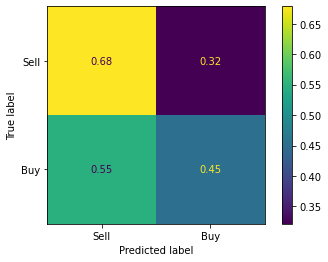

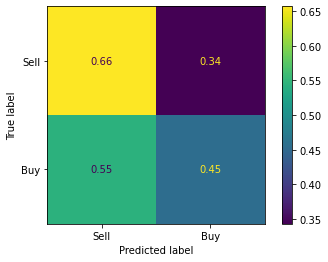

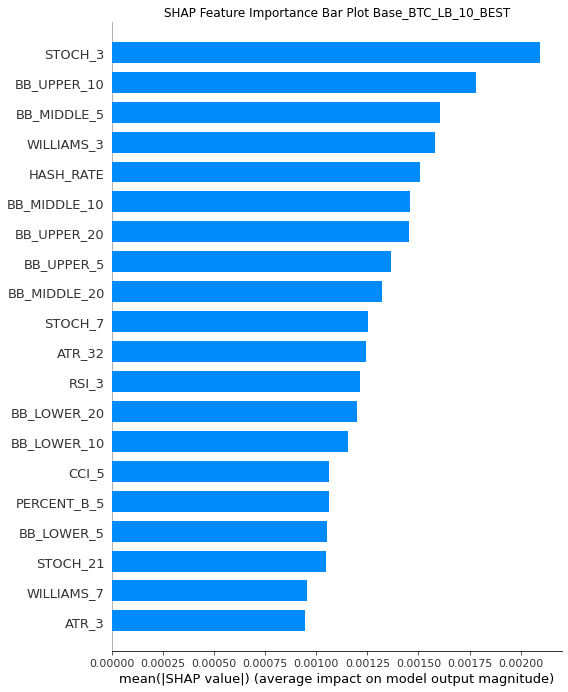

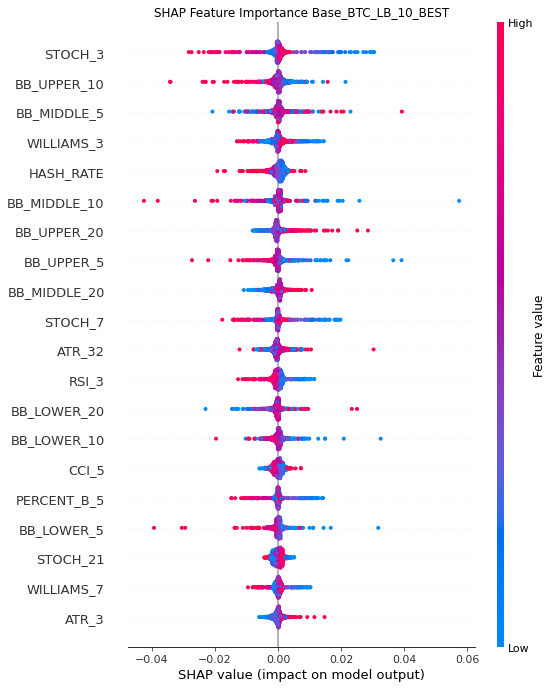

---------------------- Base_ETH_LB_10 ----------------------
{'dropout': 0.0, 'units_1': 32, 'num_layers': 1, 'units_last': 32, 'dense_units': 128, 'dropout_last': 0.4, 'lr': 0.0053546557434547785, 'units_2': 135, 'units_3': 320, 'units_4': 48, 'units_5': 185, 'units_6': 134}


"models_predict_1hr/Base_ETH_LB_10 best trail ids: ['24', '19', '27', '30', '26']"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 32)            13312     
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,305
Trainable params: 34,305
Non-traina

None

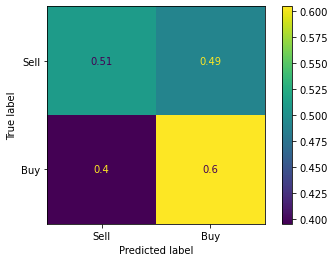

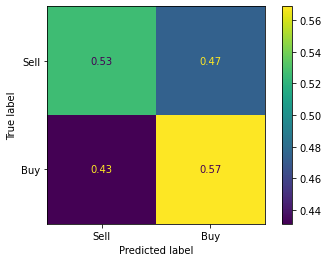

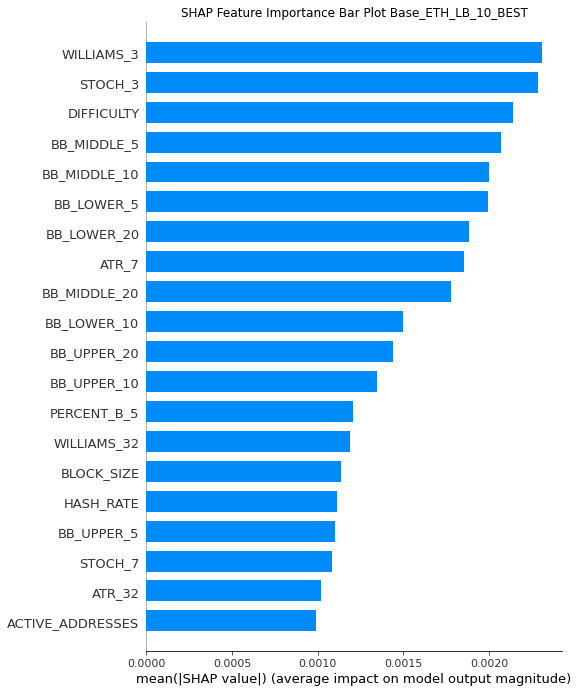

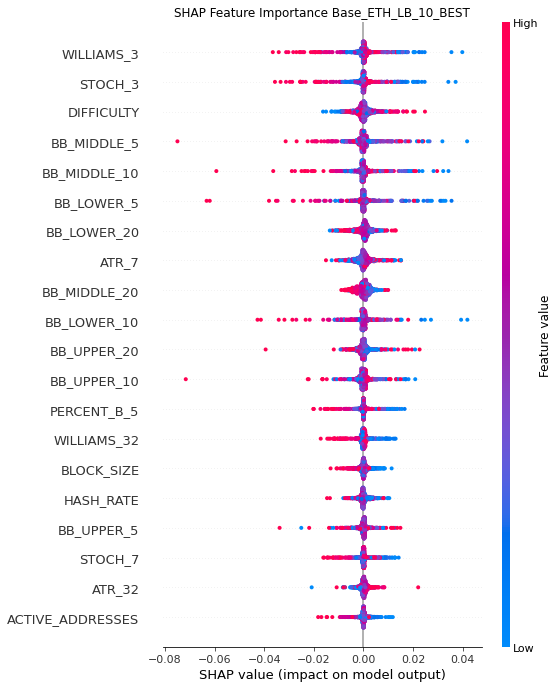

---------------------- Base_BTC_LB_30 ----------------------
{'dropout': 0.0, 'units_1': 88, 'num_layers': 1, 'units_last': 320, 'dense_units': 128, 'dropout_last': 0.4, 'lr': 0.0037336996707721007, 'units_2': 320, 'units_3': 178, 'units_4': 32, 'units_5': 32, 'units_6': 320}


"models_predict_1hr/Base_BTC_LB_30 best trail ids: ['19', '12', '16', '20', '09']"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 88)            56320     
                                                                 
 lstm_1 (LSTM)               (None, 30, 88)            62304     
                                                                 
 lstm_2 (LSTM)               (None, 320)               523520    
                                                                 
 dense (Dense)               (None, 128)               41088     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 683,361
Trainable params: 683,361
Non-trai

None

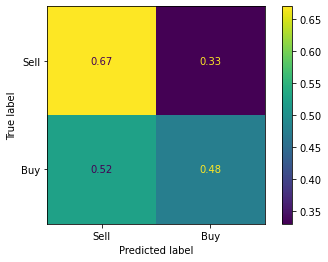

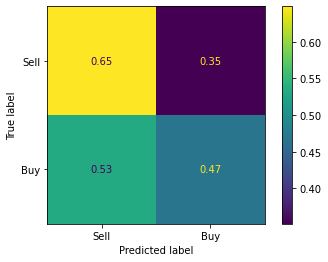

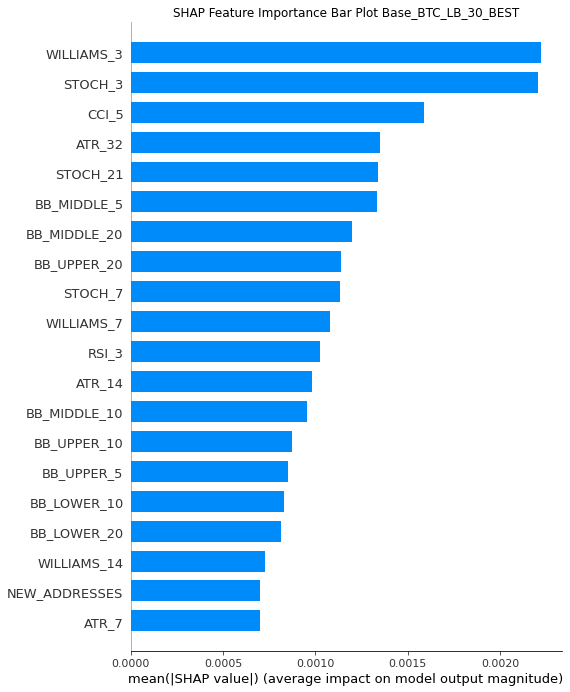

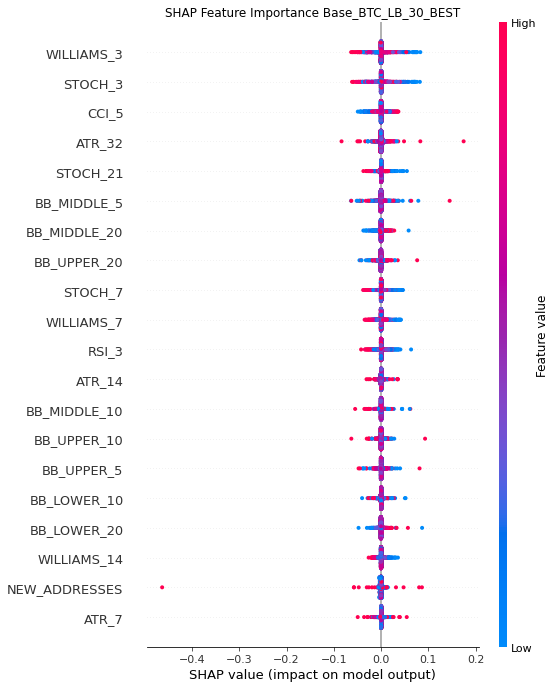

---------------------- Base_ETH_LB_30 ----------------------
{'dropout': 0.0, 'units_1': 32, 'num_layers': 1, 'units_last': 320, 'dense_units': 128, 'dropout_last': 0.4, 'lr': 0.01, 'units_2': 32, 'units_3': 320, 'units_4': 320}


"models_predict_1hr/Base_ETH_LB_30 best trail ids: ['31', '41', '18', '45', '17']"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            13312     
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 320)               451840    
                                                                 
 dense (Dense)               (None, 128)               41088     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 514,689
Trainable params: 514,689
Non-trai

None

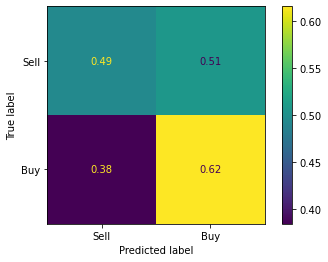

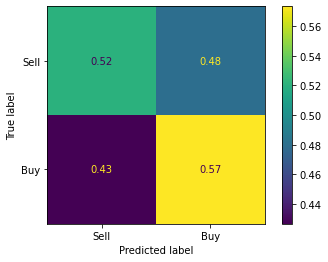

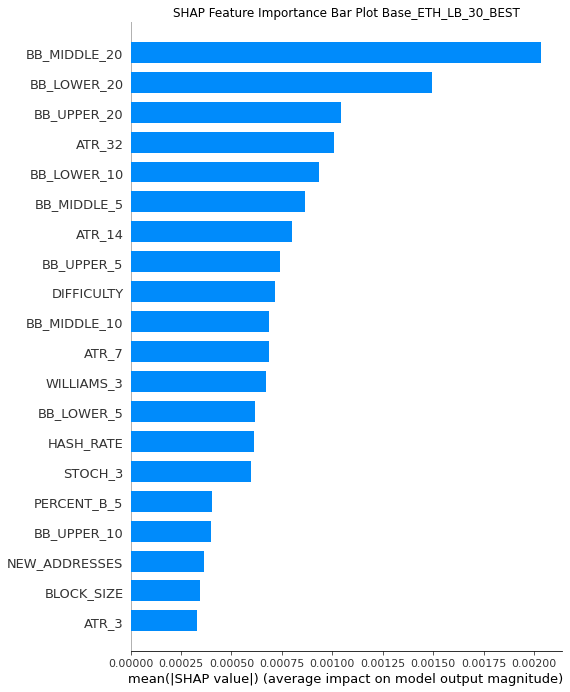

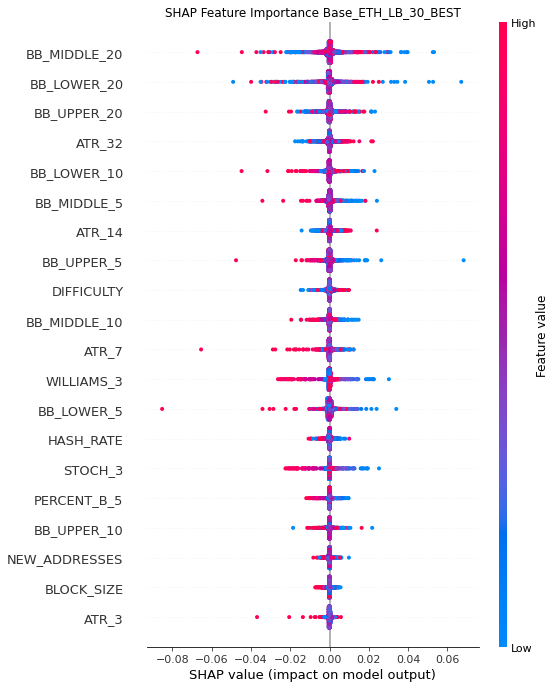

---------------------- Base_BTC_LB_60 ----------------------
{'dropout': 0.0, 'units_1': 320, 'num_layers': 1, 'units_last': 320, 'dense_units': 32, 'dropout_last': 0.1, 'lr': 0.0001, 'units_2': 32, 'units_3': 32, 'units_4': 320, 'units_5': 32, 'units_6': 320}


"models_predict_1hr/Base_BTC_LB_60 best trail ids: ['45', '48', '17', '27', '18']"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 320)           501760    
                                                                 
 lstm_1 (LSTM)               (None, 60, 320)           820480    
                                                                 
 lstm_2 (LSTM)               (None, 320)               820480    
                                                                 
 dense (Dense)               (None, 32)                10272     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,153,025
Trainable params: 2,153,025
Non-

None

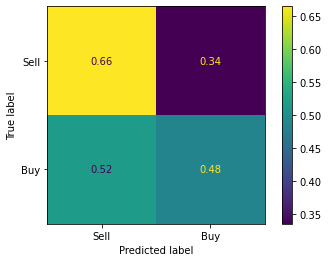

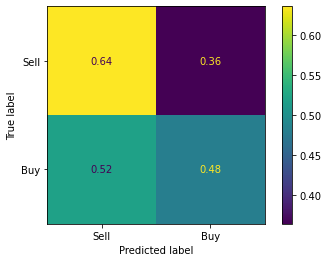

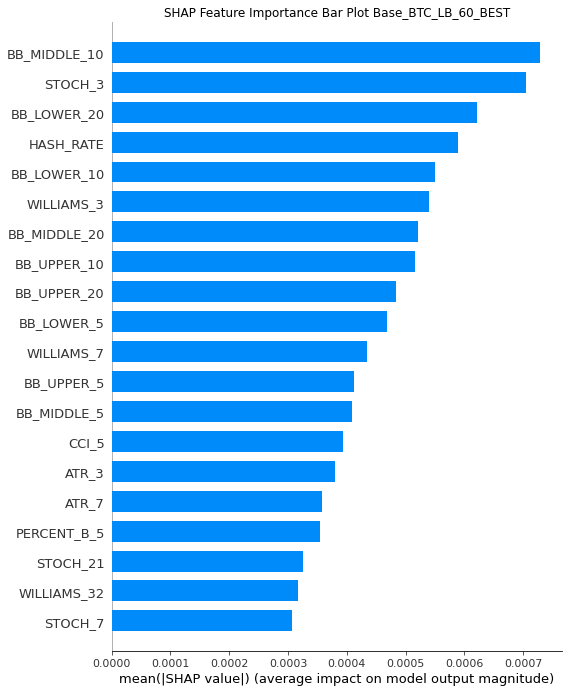

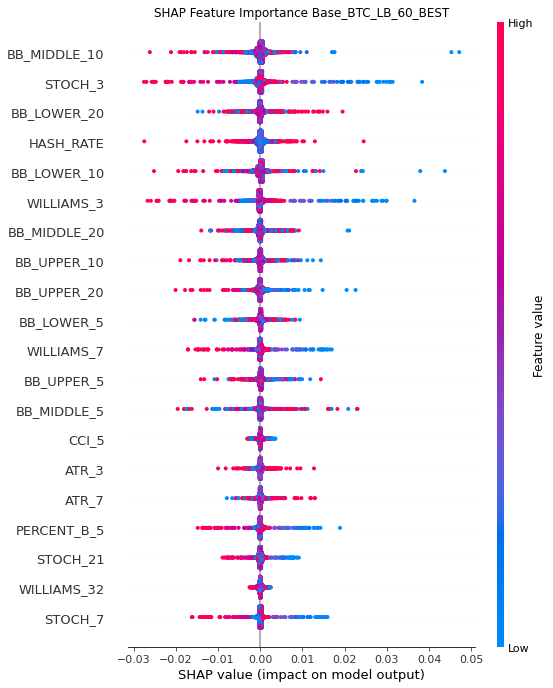

---------------------- Base_ETH_LB_60 ----------------------
{'dropout': 0.2, 'units_1': 32, 'num_layers': 1, 'units_last': 32, 'dense_units': 32, 'dropout_last': 0.1, 'lr': 0.01, 'units_2': 121, 'units_3': 32, 'units_4': 320, 'units_5': 32, 'units_6': 32}


"models_predict_1hr/Base_ETH_LB_60 best trail ids: ['18', '44', '17', '35', '41']"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 32)            13312     
                                                                 
 lstm_1 (LSTM)               (None, 60, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,041
Trainable params: 31,041
Non-traina

None

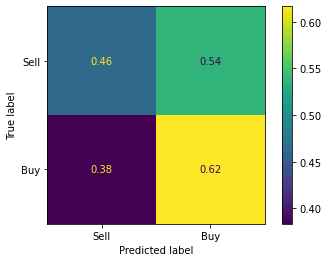

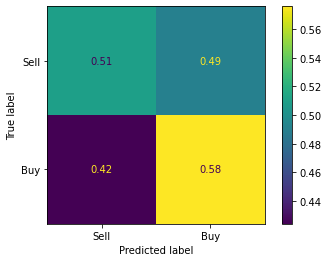

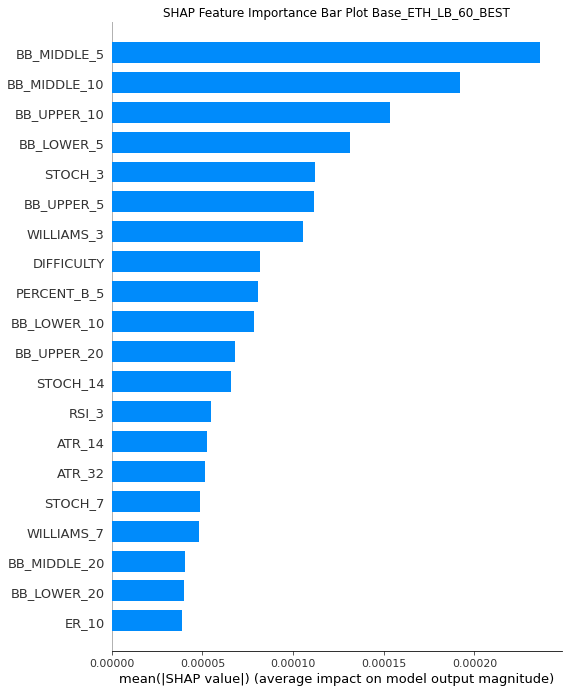

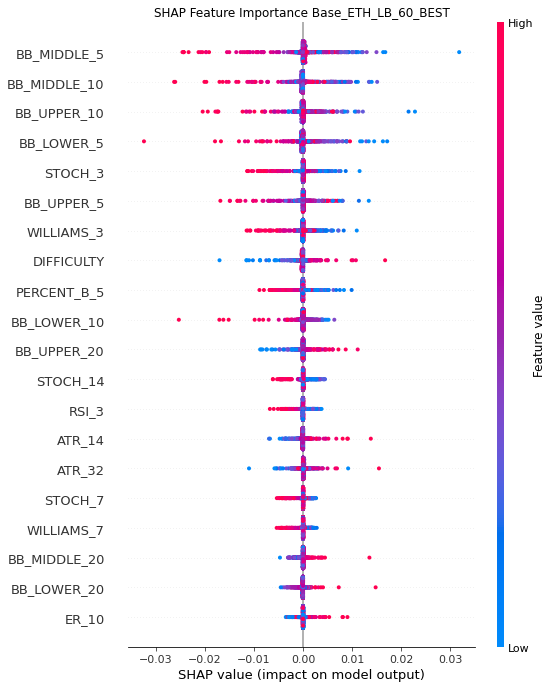

In [17]:
results.append(get_models_best("models_predict_1hr", model_types, print_shap=True, project_name='models'))

# Features Selection Models

---------------------- Feature_selected_BTC ----------------------
{'dropout': 0.1, 'units_1': 32, 'num_layers': 2, 'units_last': 320, 'dense_units': 128, 'dropout_last': 0.2, 'lr': 0.01, 'units_2': 32, 'units_3': 48, 'units_4': 32, 'units_5': 196, 'units_6': 320}


"models_predict_1hr/Feature_selected_BTC best trail ids: ['20', '42', '32', '23', '21']"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 32)            5760      
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 320)               451840    
                                                                 
 dense (Dense)               (None, 128)               41088     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

None

---------------------- Feature_selected_ETH ----------------------
{'dropout': 0.0, 'units_1': 320, 'num_layers': 1, 'units_last': 320, 'dense_units': 128, 'dropout_last': 0.1, 'lr': 0.0019275300276283271, 'units_2': 32, 'units_3': 177, 'units_4': 32, 'units_5': 320, 'units_6': 320}


"models_predict_1hr/Feature_selected_ETH best trail ids: ['35', '19', '40', '25', '48']"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 320)           419840    
                                                                 
 lstm_1 (LSTM)               (None, 10, 320)           820480    
                                                                 
 lstm_2 (LSTM)               (None, 320)               820480    
                                                                 
 dense (Dense)               (None, 128)               41088     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,102,017
Trainable params: 2,102,017
Non-

None

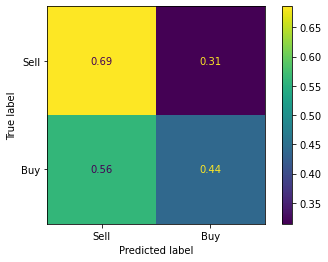

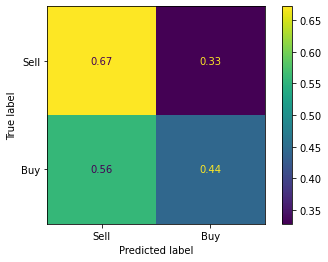

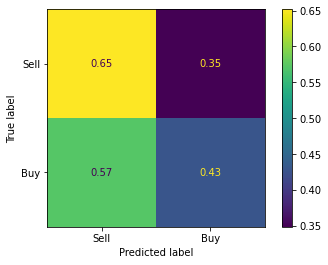

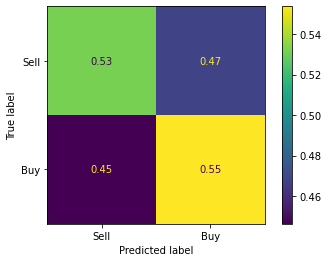

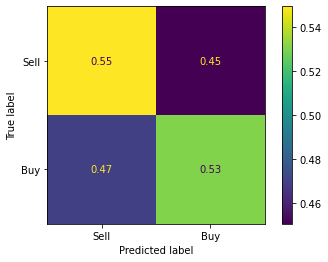

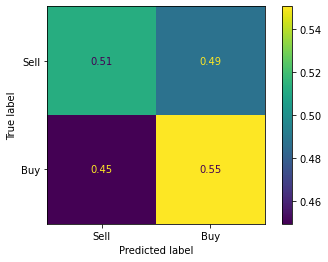

In [18]:
results.append(get_models_best("models_predict_1hr", ['Feature_selected_BTC', 'Feature_selected_ETH'], project_name='models'))

# Autoencoder Models

---------------------- Autoencoder_BTC ----------------------
{'dropout': 0.4, 'units_1': 167, 'num_layers': 1, 'units_last': 32, 'dense_units': 72, 'dropout_last': 0.4, 'lr': 0.00041894915566131446, 'units_2': 108, 'units_3': 32, 'units_4': 320, 'units_5': 305, 'units_6': 320}


"models_predict_1hr/Autoencoder_BTC best trail ids: ['30', '19', '43', '41', '16']"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 167)           118904    
                                                                 
 lstm_1 (LSTM)               (None, 10, 167)           223780    
                                                                 
 lstm_2 (LSTM)               (None, 32)                25600     
                                                                 
 dense (Dense)               (None, 72)                2376      
                                                                 
 dropout (Dropout)           (None, 72)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 73        
                                                                 
Total params: 370,733
Trainable params: 370,733
Non-trai

None

---------------------- Autoencoder_ETH ----------------------
{'dropout': 0.4, 'units_1': 279, 'num_layers': 1, 'units_last': 320, 'dense_units': 67, 'dropout_last': 0.1, 'lr': 0.01, 'units_2': 32, 'units_3': 32, 'units_4': 320, 'units_5': 32, 'units_6': 79}


"models_predict_1hr/Autoencoder_ETH best trail ids: ['44', '25', '43', '19', '13']"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 279)           323640    
                                                                 
 lstm_1 (LSTM)               (None, 10, 279)           623844    
                                                                 
 lstm_2 (LSTM)               (None, 320)               768000    
                                                                 
 dense (Dense)               (None, 67)                21507     
                                                                 
 dropout (Dropout)           (None, 67)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 68        
                                                                 
Total params: 1,737,059
Trainable params: 1,737,059
Non-

None

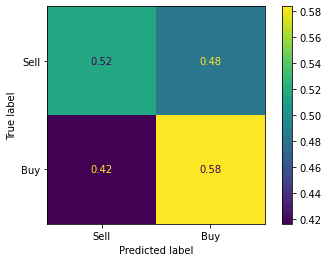

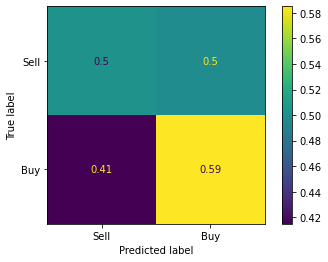

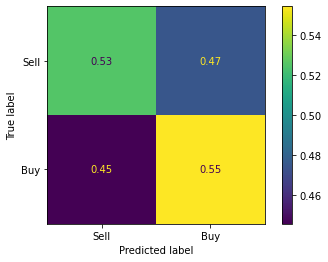

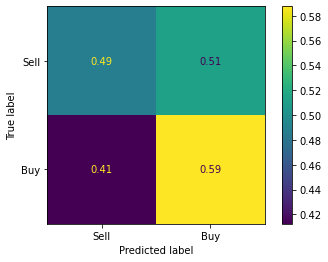

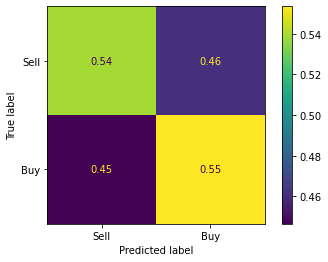

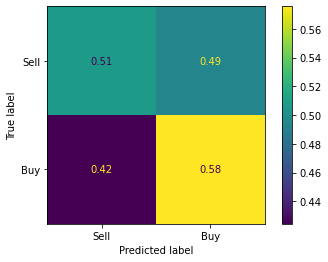

In [19]:
results.append(get_models_best("models_predict_1hr", ['Autoencoder_BTC', 'Autoencoder_ETH'], project_name='models'))

# Collate Results

In [20]:
x = {'train': [], 'val': [], 'test': []}
for r in results:
    x['train'].append(pd.DataFrame(r[0]))
    x['val'].append(pd.DataFrame(r[1]))
    x['test'].append(pd.DataFrame(r[2]))

train_df = pd.concat(x['train'])
val_df = pd.concat(x['val'])
test_df = pd.concat(x['test'])

In [21]:
display(train_df)
display(val_df)
display(test_df)

,log_val,accuracy_val,f_1,recall,precision,auc,model,project
0,0.682412,0.560739,0.516939,0.452041,0.603595,0.565253,Base_BTC_LB_10,models
1,0.685162,0.558171,0.582394,0.604120,0.562177,0.557235,Base_ETH_LB_10,models
2,0.702397,0.568237,0.533570,0.475002,0.608612,0.572103,Base_BTC_LB_30,models
3,0.684961,0.555736,0.585511,0.615612,0.558217,0.554550,Base_ETH_LB_30,models
4,0.676500,0.571032,0.540007,0.484274,0.610237,0.574636,Base_BTC_LB_60,models
5,0.689610,0.541768,0.578340,0.616659,0.544505,0.540302,Base_ETH_LB_60,models
0,0.690548,0.558004,0.508622,0.439942,0.602714,0.562914,Feature_selected_BTC,models
1,0.693419,0.542952,0.554080,0.553643,0.554517,0.542669,Feature_selected_ETH,models
0,0.688137,0.551709,0.575130,0.583564,0.566936,0.550386,Autoencoder_BTC,models
1,0.690953,0.538605,0.565040,0.587652,0.544103,0.537606,Autoencoder_ETH,models


,log_val,accuracy_val,f_1,recall,precision,auc,model,project
0,0.685514,0.553788,0.509886,0.454688,0.580338,0.555908,Base_BTC_LB_10,models
1,0.689698,0.548274,0.566399,0.568706,0.564111,0.547476,Base_ETH_LB_10,models
2,0.723752,0.555822,0.517861,0.467173,0.580887,0.557744,Base_BTC_LB_30,models
3,0.690117,0.547640,0.567914,0.573190,0.562734,0.546651,Base_ETH_LB_30,models
4,0.688335,0.556172,0.524683,0.480014,0.578518,0.557777,Base_BTC_LB_60,models
5,0.689559,0.544157,0.567290,0.576079,0.558764,0.542918,Base_ETH_LB_60,models
0,0.692490,0.555099,0.504207,0.443228,0.584642,0.557476,Feature_selected_BTC,models
1,0.695109,0.539506,0.544501,0.530492,0.559269,0.539858,Feature_selected_ETH,models
0,0.688682,0.544449,0.567361,0.585149,0.550623,0.543578,Autoencoder_BTC,models
1,0.690682,0.546476,0.558733,0.553457,0.564112,0.546204,Autoencoder_ETH,models


,log_val,accuracy_val,f_1,recall,precision,auc,model,project
0,0.693220,0.529000,0.458922,0.393393,0.550644,0.531132,Base_BTC_LB_10,models
1,0.696636,0.537009,0.563655,0.592797,0.537243,0.536508,Base_ETH_LB_10,models
2,0.751370,0.533649,0.487112,0.436205,0.551471,0.535171,Base_BTC_LB_30,models
3,0.696822,0.533832,0.564405,0.598892,0.533673,0.533270,Base_ETH_LB_30,models
4,0.701435,0.528843,0.485566,0.438024,0.544686,0.530252,Base_BTC_LB_60,models
5,0.690922,0.537086,0.570854,0.610206,0.536271,0.536412,Base_ETH_LB_60,models
0,0.702907,0.538277,0.485039,0.428295,0.559116,0.539999,Feature_selected_BTC,models
1,0.700553,0.531655,0.542516,0.550446,0.534811,0.531484,Feature_selected_ETH,models
0,0.689955,0.539936,0.550270,0.554332,0.546268,0.539710,Autoencoder_BTC,models
1,0.691096,0.541416,0.558796,0.575682,0.542872,0.541108,Autoencoder_ETH,models


In [22]:
train_df.to_csv('best_models/train.csv')
val_df.to_csv('best_models/validation.csv')
test_df.to_csv('best_models/test.csv')

# Experiement with t-sne to visualise autoencoders

In [14]:
from controllers.utils import load

m = load("/home/williamharris/Dev/CQF_final_project/models_predict_1hr/BTC_autoencoder_model/BTC_autoencoder_model/model.pickle")

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot

def run_tsne(X, y):
    x_compressed = m.model.get_layer("encoder").predict(X)
    X = np.zeros((x_compressed.shape[0], 10 * 10))
    for i in range(x_compressed.shape[0]):
        X[i] = x_compressed[i].flatten()
    pca = PCA(n_components=10)
    X_pca = pca.fit_transform(X) 
    tsne = TSNE(random_state=0, verbose=2, perplexity=1000, learning_rate='auto')
    x_compressed_2d = tsne.fit_transform(X_pca)
    pyplot.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c=y, s=30)
    pyplot.gcf().set_size_inches(12, 12)
    pyplot.show()

[t-SNE] Computing 3001 nearest neighbors...
[t-SNE] Indexed 16276 samples in 0.052s...
[t-SNE] Computed neighbors for 16276 samples in 14.261s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16276
[t-SNE] Computed conditional probabilities for sample 2000 / 16276
[t-SNE] Computed conditional probabilities for sample 3000 / 16276
[t-SNE] Computed conditional probabilities for sample 4000 / 16276
[t-SNE] Computed conditional probabilities for sample 5000 / 16276
[t-SNE] Computed conditional probabilities for sample 6000 / 16276
[t-SNE] Computed conditional probabilities for sample 7000 / 16276
[t-SNE] Computed conditional probabilities for sample 8000 / 16276
[t-SNE] Computed conditional probabilities for sample 9000 / 16276
[t-SNE] Computed conditional probabilities for sample 10000 / 16276
[t-SNE] Computed conditional probabilities for sample 11000 / 16276
[t-SNE] Computed conditional probabilities for sample 12000 / 16276
[t-SNE] Computed conditional probabilities for 

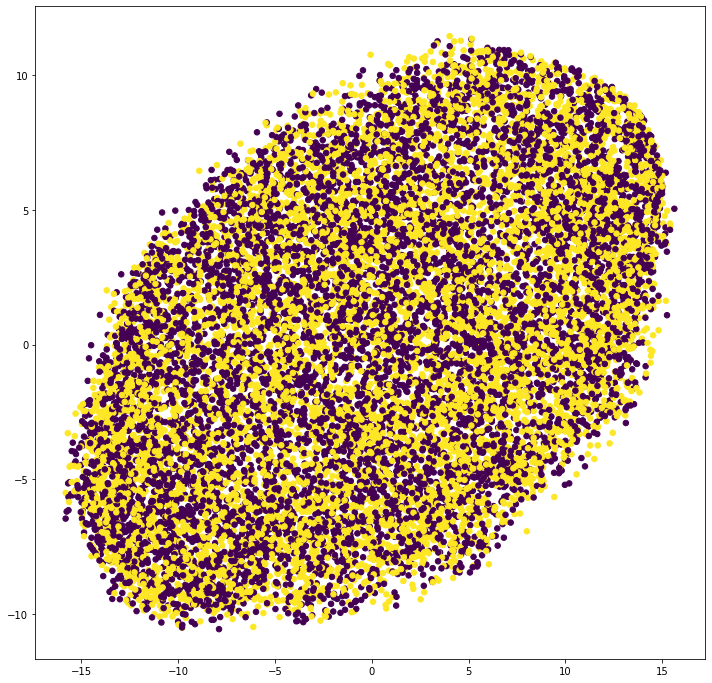

In [16]:
run_tsne(m.dataset.X_test, m.dataset.y_test)